The analysis for the 2023/02/21 run.

In [1]:
import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, '/afs/cern.ch/user/j/jcapotor/FBGana/src')
sys.path.insert(1, '/afs/cern.ch/user/j/jcapotor/FBGana/ana_tools')
import manage_data
import getters
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import norm
plt.style.use('./presentation.mplstyle')

In [2]:
path_to_split_21 = "/eos/user/j/jcapotor/FBGana/camara_climatica/FebruaryRuns/20230222/"

The temperature profile registered by the RTD1 during that run.

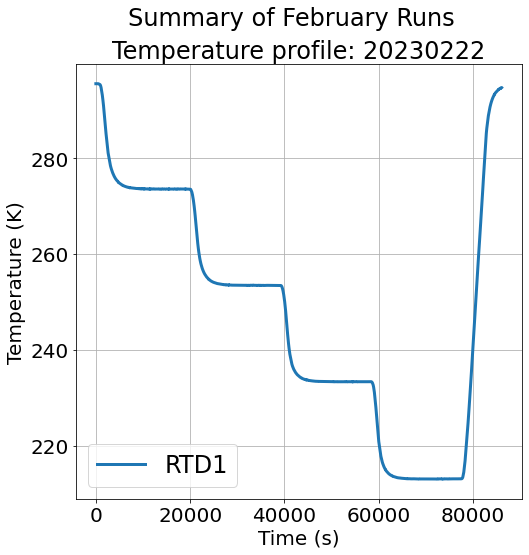

In [3]:
tprofile21_fig, tprofile21_ax = plt.subplots(nrows=1, ncols=1)
tprofile21_fig.set_size_inches(8, 8)
tprofile21_fig.suptitle("Summary of February Runs")
date = path_to_split_21.split("/")[-2]
temp = pd.read_csv(path_to_split_21+"temperature.txt", header=0)
t0 = temp["Timestamp"][0]
tprofile21_ax.plot(temp["Timestamp"]-temp["Timestamp"][0], temp["T1"], label="RTD1")
tprofile21_ax.set_title("Temperature profile: " + date)
tprofile21_ax.set_xlabel("Time (s)")
tprofile21_ax.set_ylabel("Temperature (K)")
tprofile21_ax.grid("on")
tprofile21_ax.legend()

In [4]:
plateau_21 = {"273_down":[14000,19800], "253_down":[34000,39000], "233_down":[53000,58200], "213_down":[68000,77300]}

In [5]:
def create_figure(nrows=2, ncols=2):
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols)
    axes = []
    for i in ax:
        for j in i:
            axes.append(j)
    return fig, axes

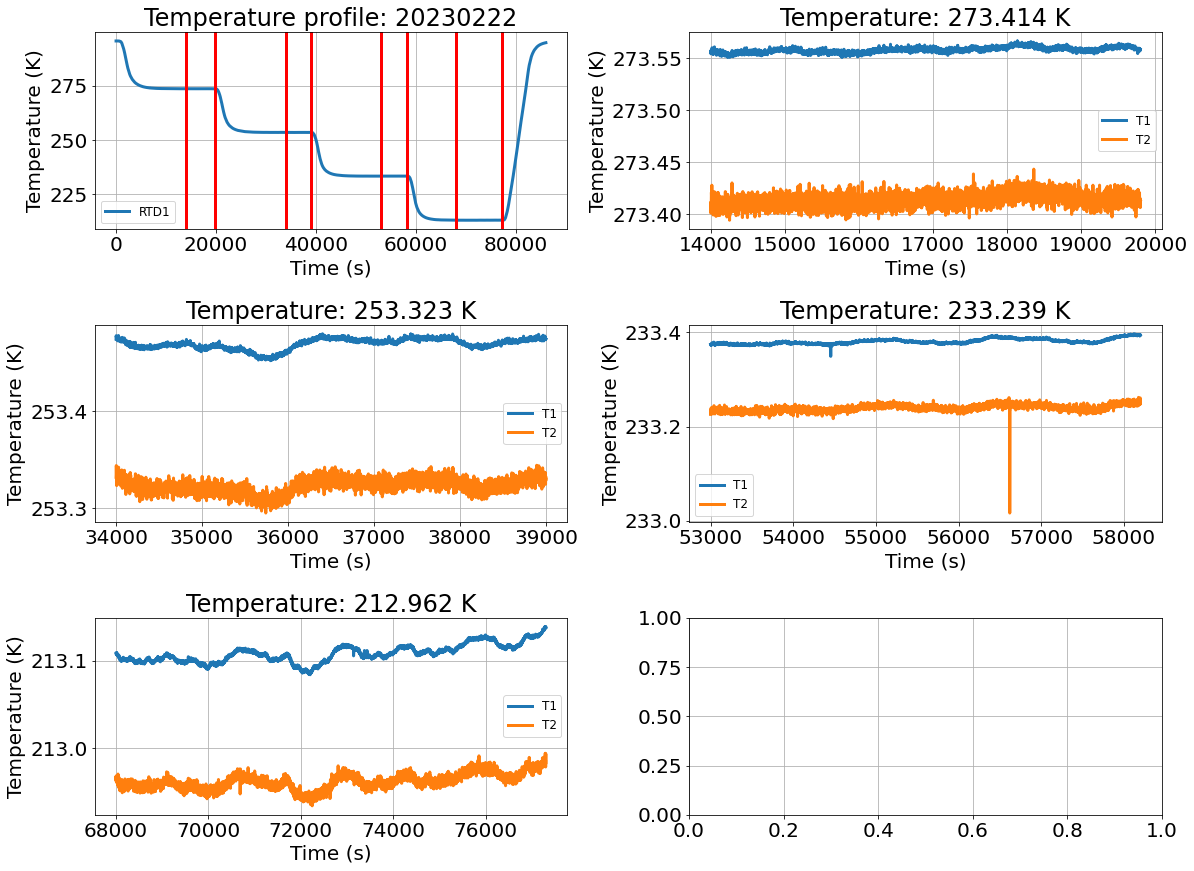

In [6]:
t0 = temp["Timestamp"][0]
temp_plateau21_fig, temp_plateau21_ax = create_figure(nrows=3, ncols=2)
temp_plateau21_fig.set_size_inches(17, 12.5)
cnt = 1
temp_plateau21_ax[0].plot(temp["Timestamp"]-t0, temp["T1"], label="RTD1")
temp_plateau21_ax[0].set_title("Temperature profile: " + date)
temp_plateau21_ax[0].set_xlabel("Time (s)")
temp_plateau21_ax[0].set_ylabel("Temperature (K)")
temp_plateau21_ax[0].legend(fontsize=12)
for key in plateau_21.keys():
    for col in temp.columns:
        if col == "Datetime" or col=="Timestamp" or col == "Date" or col =="Time" or col =="Unnamed: 0" or col[-1]=="r":
            continue
        temp_plateau21_ax[0].axvline(x=plateau_21[key][0], color="red")
        temp_plateau21_ax[0].axvline(x=plateau_21[key][1], color="red")
        temp_plateau21_ax[cnt].plot(temp.loc[(temp["Timestamp"]-t0 > plateau_21[key][0]) & (temp["Timestamp"]-t0 < plateau_21[key][1])]["Timestamp"] -t0,
        temp.loc[(temp["Timestamp"]-t0 > plateau_21[key][0]) & (temp["Timestamp"]-t0 < plateau_21[key][1])][col],
        label=col
        )
        temp_plateau21_ax[cnt].set_title("Temperature: " + str(np.round(np.mean(temp.loc[(temp["Timestamp"]-t0 > plateau_21[key][0]) & (temp["Timestamp"]-t0 < plateau_21[key][1])][col]),3)) + " K")
        temp_plateau21_ax[cnt].set_xlabel("Time (s)")
        temp_plateau21_ax[cnt].set_ylabel("Temperature (K)")
        temp_plateau21_ax[cnt].legend(fontsize=12)
    cnt += 1
temp_plateau21_fig.tight_layout()

The wavelength profile registered by the first sensor of the FBG3 (Wav1-1), considering the acerage polarisation.

In [7]:
peaks21_p = getters.get_data(path_to_split=path_to_split_21, pol="P")
peaks21_s = getters.get_data(path_to_split=path_to_split_21, pol="S")

In [ ]:
peaks_21_av = (peaks21_p + peaks21_s)/2
peaks_21_av = peaks_21_av.loc[(peaks_21_av["Wav1-1"]*1e9>1530)]

In [ ]:
plateau = "273_down"
def read_peaks(
    path_to_data="",
    filename="",
    path_to_save_folder = "",
    channels = [], n_sensors=[],
    chunksize=1e6
    ):
    data = pd.read_csv(path_to_data+filename, sep="\t", header=None, chunksize=chunksize)
    names = ["Datetime", "Timestamp"]
    columns = [0,1]
    totalsensors = 0
    for chan in range(len(channels)):
        for sens in range(n_sensors[chan]):
            names.append("Wav"+str(chan+1)+"-"+str(sens+1))
            columns.append(6*totalsensors + 8)
            totalsensors += 1
    i = 1
    print(t0)
    for chunk in data:
        if i > 12:
            break
        chunk = chunk[columns]
        chunk.columns = names
        chunk = chunk.reset_index(drop=True)
        chunk["Timestamp"] = chunk["Timestamp"].apply(manage_data.time_to_seconds)
        chunk = chunk.loc[(chunk["Timestamp"]-t0>plateau_21[plateau][0])&(chunk["Timestamp"]-t0<plateau_21[plateau][1])].reset_index(drop=True)
        if len(chunk)<10:
            i += 1
            continue
        plt.plot(chunk["Timestamp"]-t0, chunk["Wav1-2"]*1e9, ".", color="blue", label="Peaks W/O downsampling")
        i += 1

plt.figure(figsize=(10,10))
read_peaks(
    path_to_data = "/eos/user/j/jcapotor/FBGdata/Data/camara_climatica/FebruaryRuns/20230221/",
    filename = "peaks.txt",
    channels=[0,1],
    n_sensors=[5,4]
)
specs_p = pd.read_csv(path_to_split_21+"P_spectrums_1.txt", header=0)

specs_p = specs_p.loc[(specs_p["Wav1-2"]>1538)].reset_index(drop=True)
specs_p = specs_p.loc[(specs_p["Timestamp"]-t0>plateau_21[plateau][0])&(specs_p["Timestamp"]-t0<plateau_21[plateau][1])].reset_index(drop=True)
peaks21_p = peaks21_p.loc[(peaks21_p["Timestamp"]-t0>plateau_21[plateau][0])&(peaks21_p["Timestamp"]-t0<plateau_21[plateau][1])].reset_index(drop=True)
peaks21_s = peaks21_s.loc[(peaks21_s["Timestamp"]-t0>plateau_21[plateau][0])&(peaks21_s["Timestamp"]-t0<plateau_21[plateau][1])].reset_index(drop=True)
plt.plot(peaks21_p["Timestamp"]-t0, peaks21_p["Wav1-2"]*1e9, color="orange", label="Peaks DOWNsampled")
plt.plot(specs_p["Timestamp"]-t0, specs_p["Wav1-2"], color="green", label="Spectrums DOWNsampled")
plt.plot(peaks21_s["Timestamp"]-t0, peaks21_s["Wav1-2"]*1e9, color="orange", label="Peaks DOWNsampled")
plt.title("Check of downsampling performance: Wav1-1")
plt.xlabel("Time (s)")
plt.ylabel("Wavelength (nm)")
plt.show()

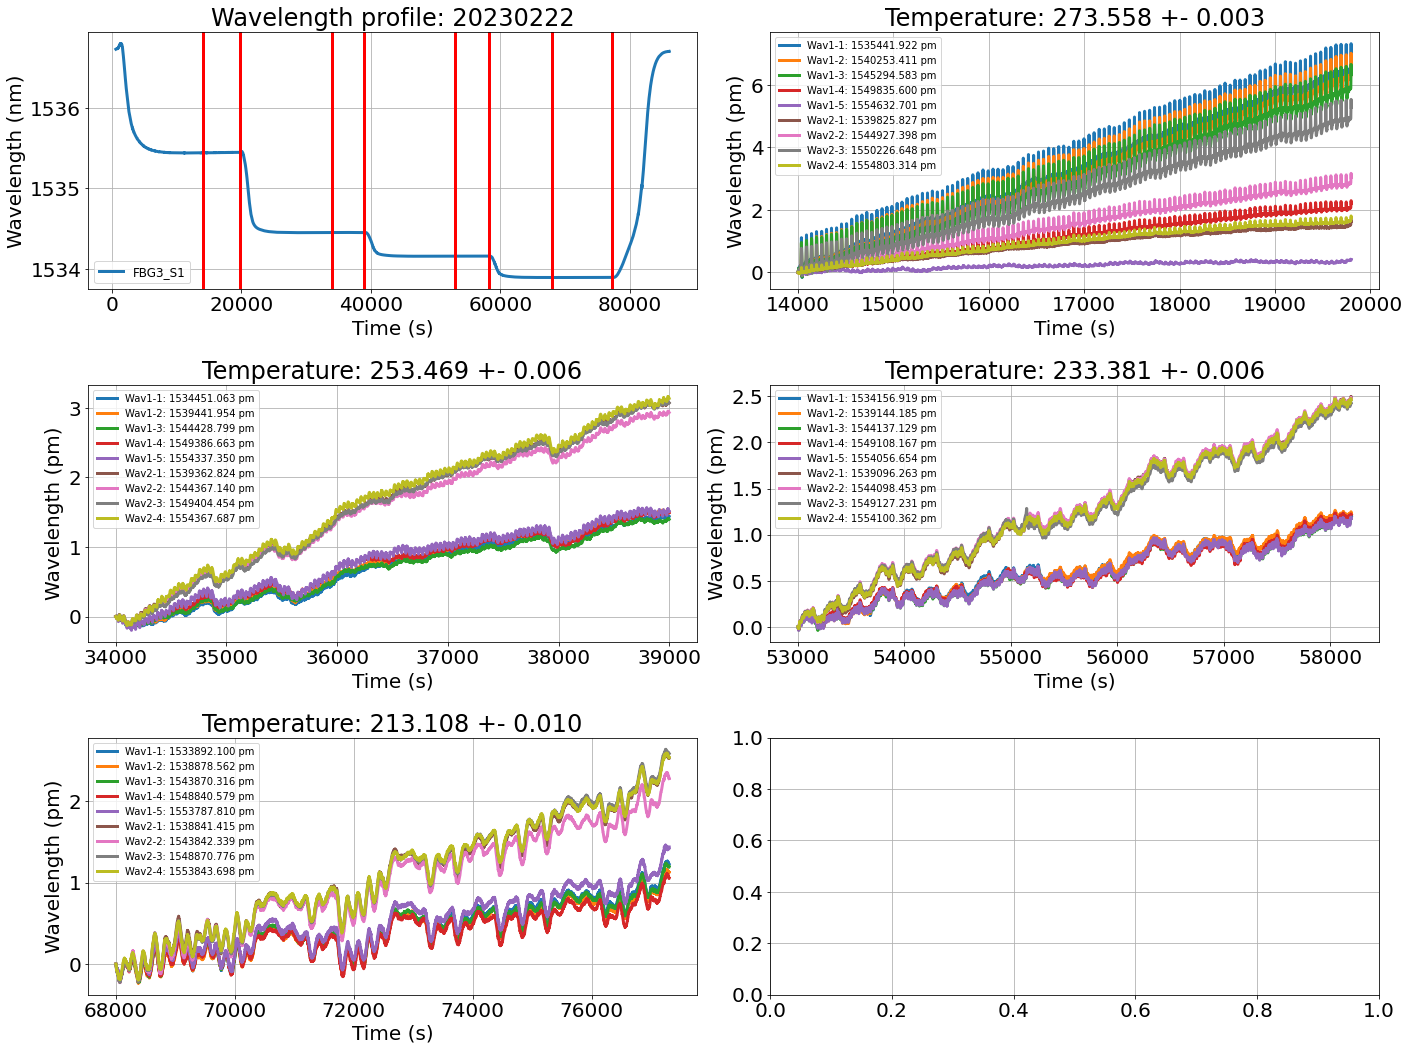

In [9]:
wav_plateau21_fig, wav_plateau21_ax = create_figure(nrows=3, ncols=2)
wav_plateau21_fig.set_size_inches(20, 15)
cnt = 1
wav_plateau21_ax[0].plot(peaks_21_av["Timestamp"]-t0, peaks_21_av["Wav1-1"]*1e9, label="FBG3_S1")
wav_plateau21_ax[0].set_title("Wavelength profile: " + date)
wav_plateau21_ax[0].set_xlabel("Time (s)")
wav_plateau21_ax[0].set_ylabel("Wavelength (nm)")
wav_plateau21_ax[0].legend(fontsize=12)
for key in plateau_21.keys():
    for col in peaks_21_av.columns:
        if col == "Datetime" or col=="Timestamp" or col == "Date" or col =="Time" or col =="Unnamed: 0" or col[-1]=="r":
            continue
        wav_plateau21_ax[0].axvline(x=plateau_21[key][0], color="red")
        wav_plateau21_ax[0].axvline(x=plateau_21[key][1], color="red")
        temp_plateau = temp.loc[(temp["Timestamp"]-t0 > plateau_21[key][0]) & (temp["Timestamp"]-t0 < plateau_21[key][1])].reset_index(drop=True)
        first_value = peaks_21_av.loc[(peaks_21_av["Timestamp"]-t0 > plateau_21[key][0]) & (peaks_21_av["Timestamp"]-t0 < plateau_21[key][1])].reset_index(drop=True)
        wav_plateau21_ax[cnt].plot(
            peaks_21_av.loc[(peaks_21_av["Timestamp"]-t0 > plateau_21[key][0]) & (peaks_21_av["Timestamp"]-t0 < plateau_21[key][1])]["Timestamp"] -t0,
            peaks_21_av.loc[(peaks_21_av["Timestamp"]-t0 > plateau_21[key][0]) & (peaks_21_av["Timestamp"]-t0 < plateau_21[key][1])][col]*1e12 - first_value[col][0]*1e12,
            label=r"{0}: {1:.3f} pm".format(col, first_value[col][0]*1e12)
        )
        wav_plateau21_ax[cnt].set_title(r"Temperature: {0:.3f} +- {1:.3f}".format(np.mean(temp_plateau["T1"]), np.std(temp_plateau["T1"])))
        wav_plateau21_ax[cnt].set_xlabel("Time (s)")
        wav_plateau21_ax[cnt].set_ylabel("Wavelength (pm)")
        wav_plateau21_ax[cnt].legend(fontsize=10)
    cnt += 1
wav_plateau21_fig.tight_layout()

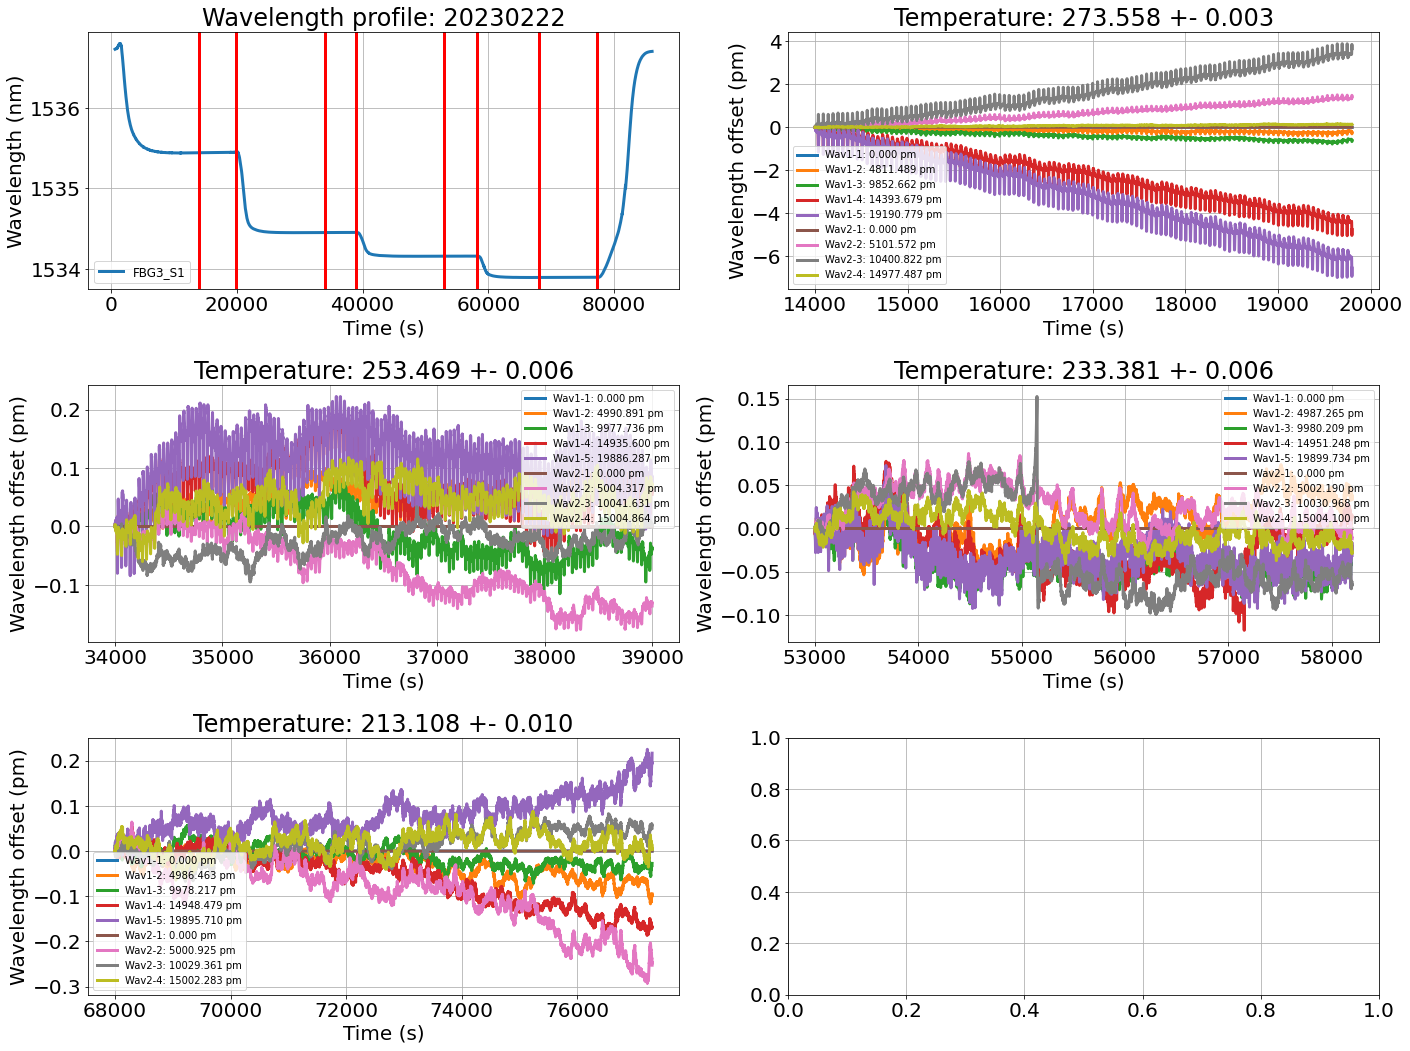

In [10]:
wavoff_plateau21_fig, wavoff_plateau21_ax = create_figure(nrows=3, ncols=2)
wavoff_plateau21_fig.set_size_inches(20, 15)
cnt = 1
wavoff_plateau21_ax[0].plot(peaks_21_av["Timestamp"]-t0, peaks_21_av["Wav1-1"]*1e9, label="FBG3_S1")
wavoff_plateau21_ax[0].set_title("Wavelength profile: " + date)
wavoff_plateau21_ax[0].set_xlabel("Time (s)")
wavoff_plateau21_ax[0].set_ylabel("Wavelength (nm)")
wavoff_plateau21_ax[0].legend(fontsize=12)
for key in plateau_21.keys():
    for col in peaks_21_av.columns:
        if col == "Datetime" or col=="Timestamp" or col == "Date" or col =="Time" or col =="Unnamed: 0" or col[-1]=="r":
            continue
        wavoff_plateau21_ax[0].axvline(x=plateau_21[key][0], color="red")
        wavoff_plateau21_ax[0].axvline(x=plateau_21[key][1], color="red")
        temp_plateau = temp.loc[(temp["Timestamp"]-t0 > plateau_21[key][0]) & (temp["Timestamp"]-t0 < plateau_21[key][1])].reset_index(drop=True)
        value = peaks_21_av.loc[(peaks_21_av["Timestamp"]-t0 > plateau_21[key][0]) & (peaks_21_av["Timestamp"]-t0 < plateau_21[key][1])].reset_index(drop=True)
        if col[3] == "2":
            wavoff_plateau21_ax[cnt].plot(
                peaks_21_av.loc[(peaks_21_av["Timestamp"]-t0 > plateau_21[key][0]) & (peaks_21_av["Timestamp"]-t0 < plateau_21[key][1])]["Timestamp"] -t0,
                (value[col] - value["Wav2-1"])*1e12 - (value[col] - value["Wav2-1"])[0]*1e12,
                label=r"{0}: {1:.3f} pm".format(col, (value[col] - value["Wav2-1"])[0]*1e12)
            )
        else:
            wavoff_plateau21_ax[cnt].plot(
                peaks_21_av.loc[(peaks_21_av["Timestamp"]-t0 > plateau_21[key][0]) & (peaks_21_av["Timestamp"]-t0 < plateau_21[key][1])]["Timestamp"] -t0,
                (value[col] - value["Wav1-1"])*1e12 - (value[col] - value["Wav1-1"])[0]*1e12,
                label=r"{0}: {1:.3f} pm".format(col, (value[col] - value["Wav1-1"])[0]*1e12)
            )
        wavoff_plateau21_ax[cnt].set_title(r"Temperature: {0:.3f} +- {1:.3f}".format(np.mean(temp_plateau["T1"]), np.std(temp_plateau["T1"])))
        wavoff_plateau21_ax[cnt].set_xlabel("Time (s)")
        wavoff_plateau21_ax[cnt].set_ylabel("Wavelength offset (pm)")
        wavoff_plateau21_ax[cnt].legend(fontsize=10)
    cnt += 1
wavoff_plateau21_fig.tight_layout()

In [11]:
from scipy.optimize import curve_fit
def line(x, A, B):
    return A + B*x

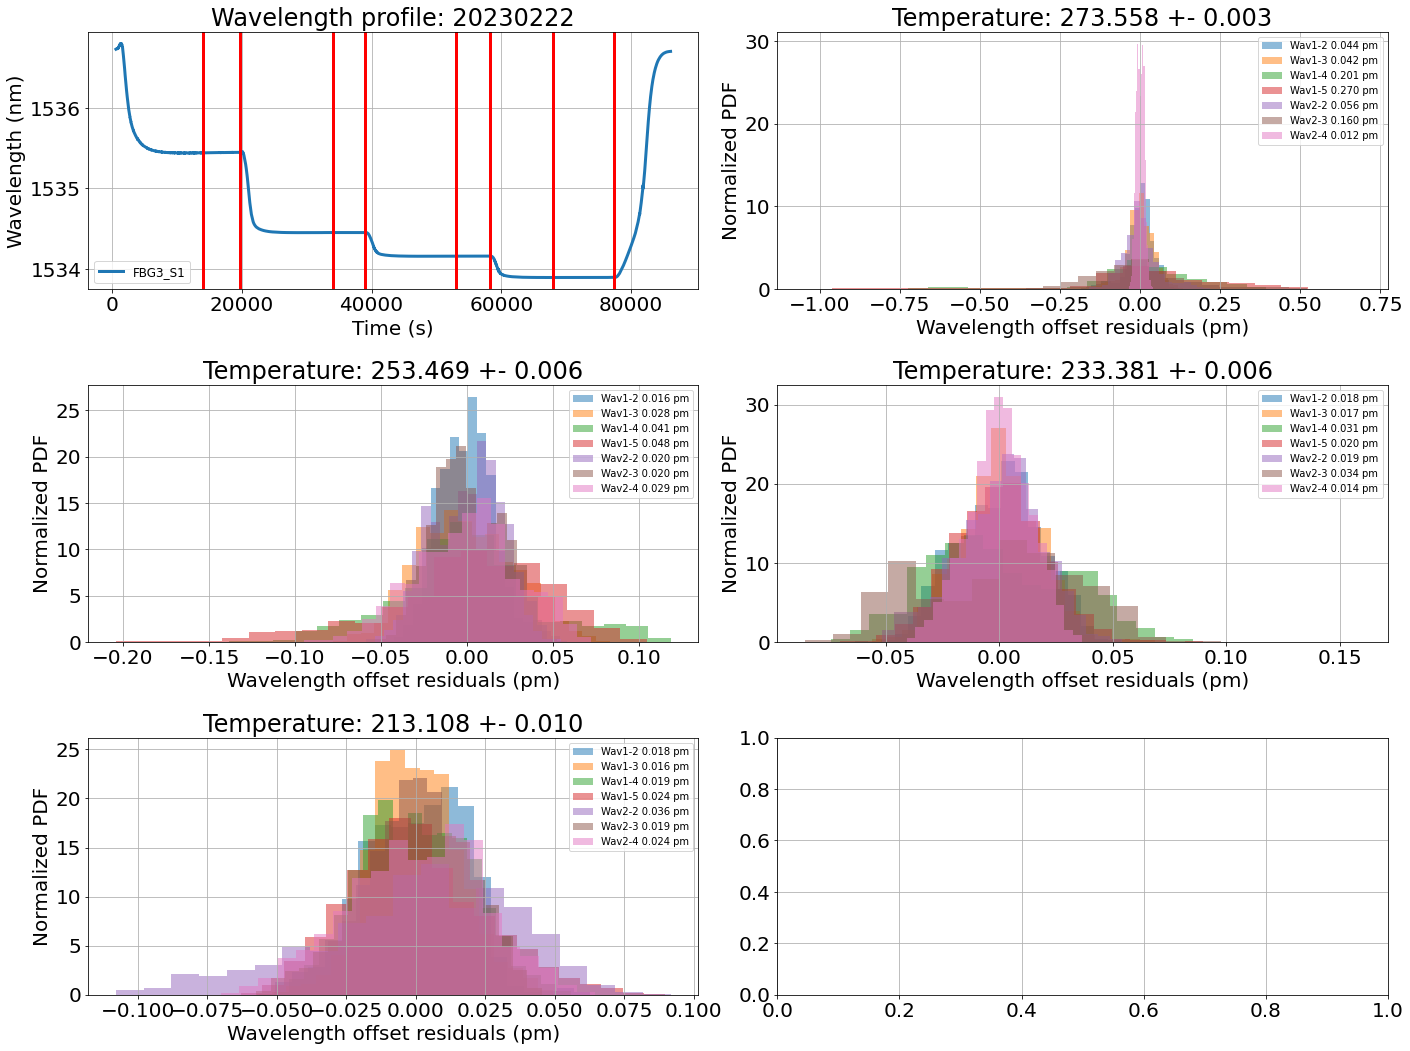

In [12]:
wavoff_plateau21_hist_fig, wavoff_plateau21_hist_ax = create_figure(nrows=3, ncols=2)
wavoff_plateau21_hist_fig.set_size_inches(20, 15)
cnt = 1
wavoff_plateau21_hist_ax[0].plot(peaks_21_av["Timestamp"]-t0, peaks_21_av["Wav1-1"]*1e9, label="FBG3_S1")
wavoff_plateau21_hist_ax[0].set_title("Wavelength profile: " + date)
wavoff_plateau21_hist_ax[0].set_xlabel("Time (s)")
wavoff_plateau21_hist_ax[0].set_ylabel("Wavelength (nm)")
wavoff_plateau21_hist_ax[0].legend(fontsize=12)
for key in plateau_21.keys():
    for col in peaks_21_av.columns:
        if col == "Datetime" or col=="Timestamp" or col == "Date" or col =="Time" or col =="Unnamed: 0" or col[-1]=="r":
            continue
        wavoff_plateau21_hist_ax[0].axvline(x=plateau_21[key][0], color="red")
        wavoff_plateau21_hist_ax[0].axvline(x=plateau_21[key][1], color="red")
        temp_plateau = temp.loc[(temp["Timestamp"]-t0 > plateau_21[key][0]) & (temp["Timestamp"]-t0 < plateau_21[key][1])].reset_index(drop=True)
        value = peaks_21_av.loc[(peaks_21_av["Timestamp"]-t0 > plateau_21[key][0]) & (peaks_21_av["Timestamp"]-t0 < plateau_21[key][1])].reset_index(drop=True)
        if col[3] == "2":
            if col == "Wav2-1":
                continue
            popt, pcov = curve_fit(line, xdata=(value["Timestamp"]-t0), ydata=(value[col] - value["Wav2-1"])*1e12 - (value[col] - value["Wav2-1"])[0]*1e12)
            wavoff_plateau21_hist_ax[cnt].hist(
                (value[col] - value["Wav2-1"])*1e12 - (value[col] - value["Wav2-1"])[0]*1e12 - line(value["Timestamp"]-t0, popt[0], popt[1]),
                label=r"{0} {1:.3f} pm".format(col, np.std((value[col] - value["Wav2-1"])*1e12 - (value[col] - value["Wav2-1"])[0]*1e12 - line(value["Timestamp"]-t0, popt[0], popt[1]))),
                bins=20,
                density="True",
                alpha=0.5
            )
        else:
            if col == "Wav1-1":
                continue
            popt, pcov = curve_fit(line, xdata=(value["Timestamp"]-t0), ydata=(value[col] - value["Wav1-1"])*1e12 - (value[col] - value["Wav1-1"])[0]*1e12)
            wavoff_plateau21_hist_ax[cnt].hist(
                (value[col] - value["Wav1-1"])*1e12 - (value[col] - value["Wav1-1"])[0]*1e12 - line(value["Timestamp"]-t0, popt[0], popt[1]),
                label=r"{0} {1:.3f} pm".format(col, np.std((value[col] - value["Wav1-1"])*1e12 - (value[col] - value["Wav1-1"])[0]*1e12 - line(value["Timestamp"]-t0, popt[0], popt[1]))),
                bins=20,
                density="True",
                alpha=0.5
            )
        wavoff_plateau21_hist_ax[cnt].set_title(r"Temperature: {0:.3f} +- {1:.3f}".format(np.mean(temp_plateau["T1"]), np.std(temp_plateau["T1"])))
        wavoff_plateau21_hist_ax[cnt].set_xlabel("Wavelength offset residuals (pm)")
        wavoff_plateau21_hist_ax[cnt].set_ylabel("Normalized PDF")
        wavoff_plateau21_hist_ax[cnt].legend(fontsize=10)
    cnt += 1
wavoff_plateau21_hist_fig.tight_layout()

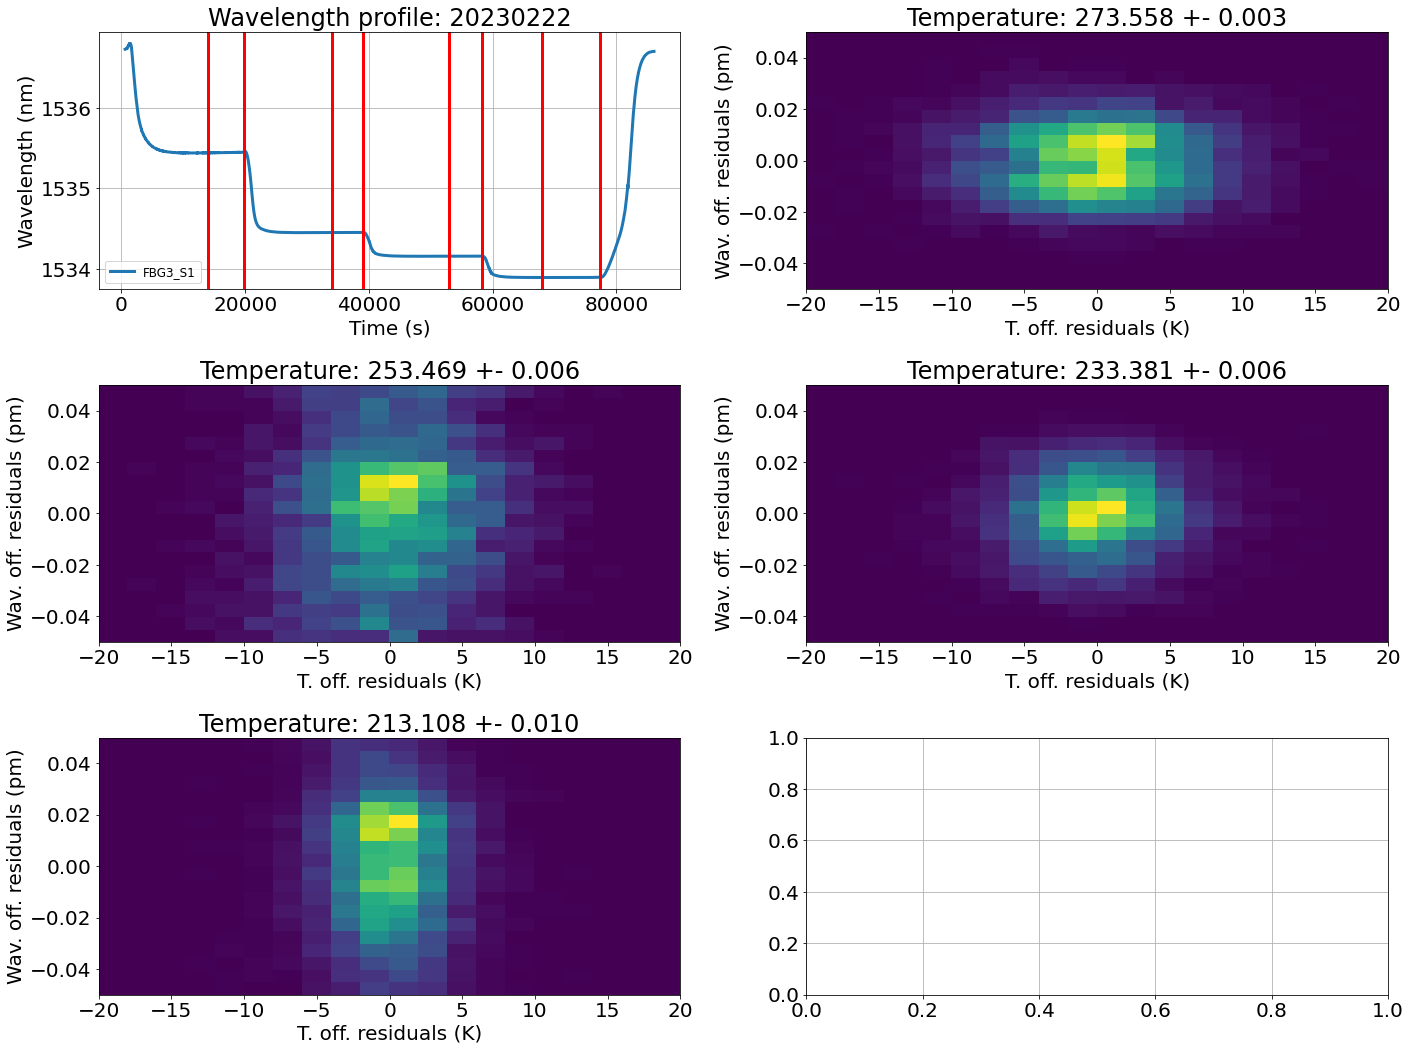

In [13]:
wavoff_plateau21_hist_fig, wavoff_plateau21_hist_ax = create_figure(nrows=3, ncols=2)
wavoff_plateau21_hist_fig.set_size_inches(20, 15)
cnt = 1
wavoff_plateau21_hist_ax[0].plot(peaks_21_av["Timestamp"]-t0, peaks_21_av["Wav1-1"]*1e9, label="FBG3_S1")
wavoff_plateau21_hist_ax[0].set_title("Wavelength profile: " + date)
wavoff_plateau21_hist_ax[0].set_xlabel("Time (s)")
wavoff_plateau21_hist_ax[0].set_ylabel("Wavelength (nm)")
wavoff_plateau21_hist_ax[0].legend(fontsize=12)
for key in plateau_21.keys():
    for col in peaks_21_av.columns:
        if col == "Datetime" or col=="Timestamp" or col == "Date" or col =="Time" or col =="Unnamed: 0" or col[-1]=="r":
            continue
        wavoff_plateau21_hist_ax[0].axvline(x=plateau_21[key][0], color="red")
        wavoff_plateau21_hist_ax[0].axvline(x=plateau_21[key][1], color="red")
        temp_plateau = temp.loc[(temp["Timestamp"]-t0 > plateau_21[key][0]) & (temp["Timestamp"]-t0 < plateau_21[key][1])].reset_index(drop=True)
        value = peaks_21_av.loc[(peaks_21_av["Timestamp"]-t0 > plateau_21[key][0]) & (peaks_21_av["Timestamp"]-t0 < plateau_21[key][1])].reset_index(drop=True)
        temp_plateau, value = manage_data.match_dataframes(temp_plateau, value)
        if col[3] == "2":
            if col == "Wav2-1":
                continue
            popt, pcov = curve_fit(line, xdata=(value["Timestamp"]-t0), ydata=(value[col] - value["Wav2-1"])*1e12 - (value[col] - value["Wav2-1"])[0]*1e12)
            popt_t, pcov = curve_fit(line, xdata=(value["Timestamp"]-t0), ydata=(temp_plateau["T1"] - temp_plateau["T2"]) - (temp_plateau["T1"] - temp_plateau["T2"])[0])
            wavoff_plateau21_hist_ax[cnt].hist2d(
                ((temp_plateau["T1"] - temp_plateau["T2"]) - (temp_plateau["T1"] - temp_plateau["T2"])[0] - line((value["Timestamp"]-t0), popt_t[0], popt_t[1]))*1e3,
                ((value[col] - value["Wav2-1"])*1e12 - (value[col] - value["Wav2-1"])[0]*1e12 - line(value["Timestamp"]-t0, popt[0], popt[1])),
                label=r"{0} {1:.3f} pm".format(col, np.std((value[col] - value["Wav2-1"])*1e12 - (value[col] - value["Wav2-1"])[0]*1e12 - line(value["Timestamp"]-t0, popt[0], popt[1]))),
                bins=20,
                range=[[-20,20],[-0.05,0.05]]
            )
        else:
            if col == "Wav1-1":
                continue
            popt, pcov = curve_fit(line, xdata=(value["Timestamp"]-t0), ydata=(value[col] - value["Wav1-1"])*1e12 - (value[col] - value["Wav1-1"])[0]*1e12)
            popt_t, pcov = curve_fit(line, xdata=(value["Timestamp"]-t0), ydata=(temp_plateau["T1"] - temp_plateau["T2"]) - (temp_plateau["T1"] - temp_plateau["T2"])[0])
            wavoff_plateau21_hist_ax[cnt].hist2d(
                ((temp_plateau["T1"] - temp_plateau["T2"]) - (temp_plateau["T1"] - temp_plateau["T2"])[0] - line((value["Timestamp"]-t0), popt_t[0], popt_t[1]))*1e3,
                ((value[col] - value["Wav1-1"])*1e12 - (value[col] - value["Wav1-1"])[0]*1e12 - line(value["Timestamp"]-t0, popt[0], popt[1])),
                label=r"{0} {1:.3f} pm".format(col, np.std((value[col] - value["Wav1-1"])*1e12 - (value[col] - value["Wav1-1"])[0]*1e12 - line(value["Timestamp"]-t0, popt[0], popt[1]))),
                bins=100,
                range=[[-20,20],[-0.05,0.05]]
                
            )
        wavoff_plateau21_hist_ax[cnt].set_title(r"Temperature: {0:.3f} +- {1:.3f}".format(np.mean(temp_plateau["T1"]), np.std(temp_plateau["T1"])))
        wavoff_plateau21_hist_ax[cnt].set_ylabel("Wav. off. residuals (pm)")
        wavoff_plateau21_hist_ax[cnt].set_xlabel("T. off. residuals (K)")
    cnt += 1
wavoff_plateau21_hist_fig.tight_layout()

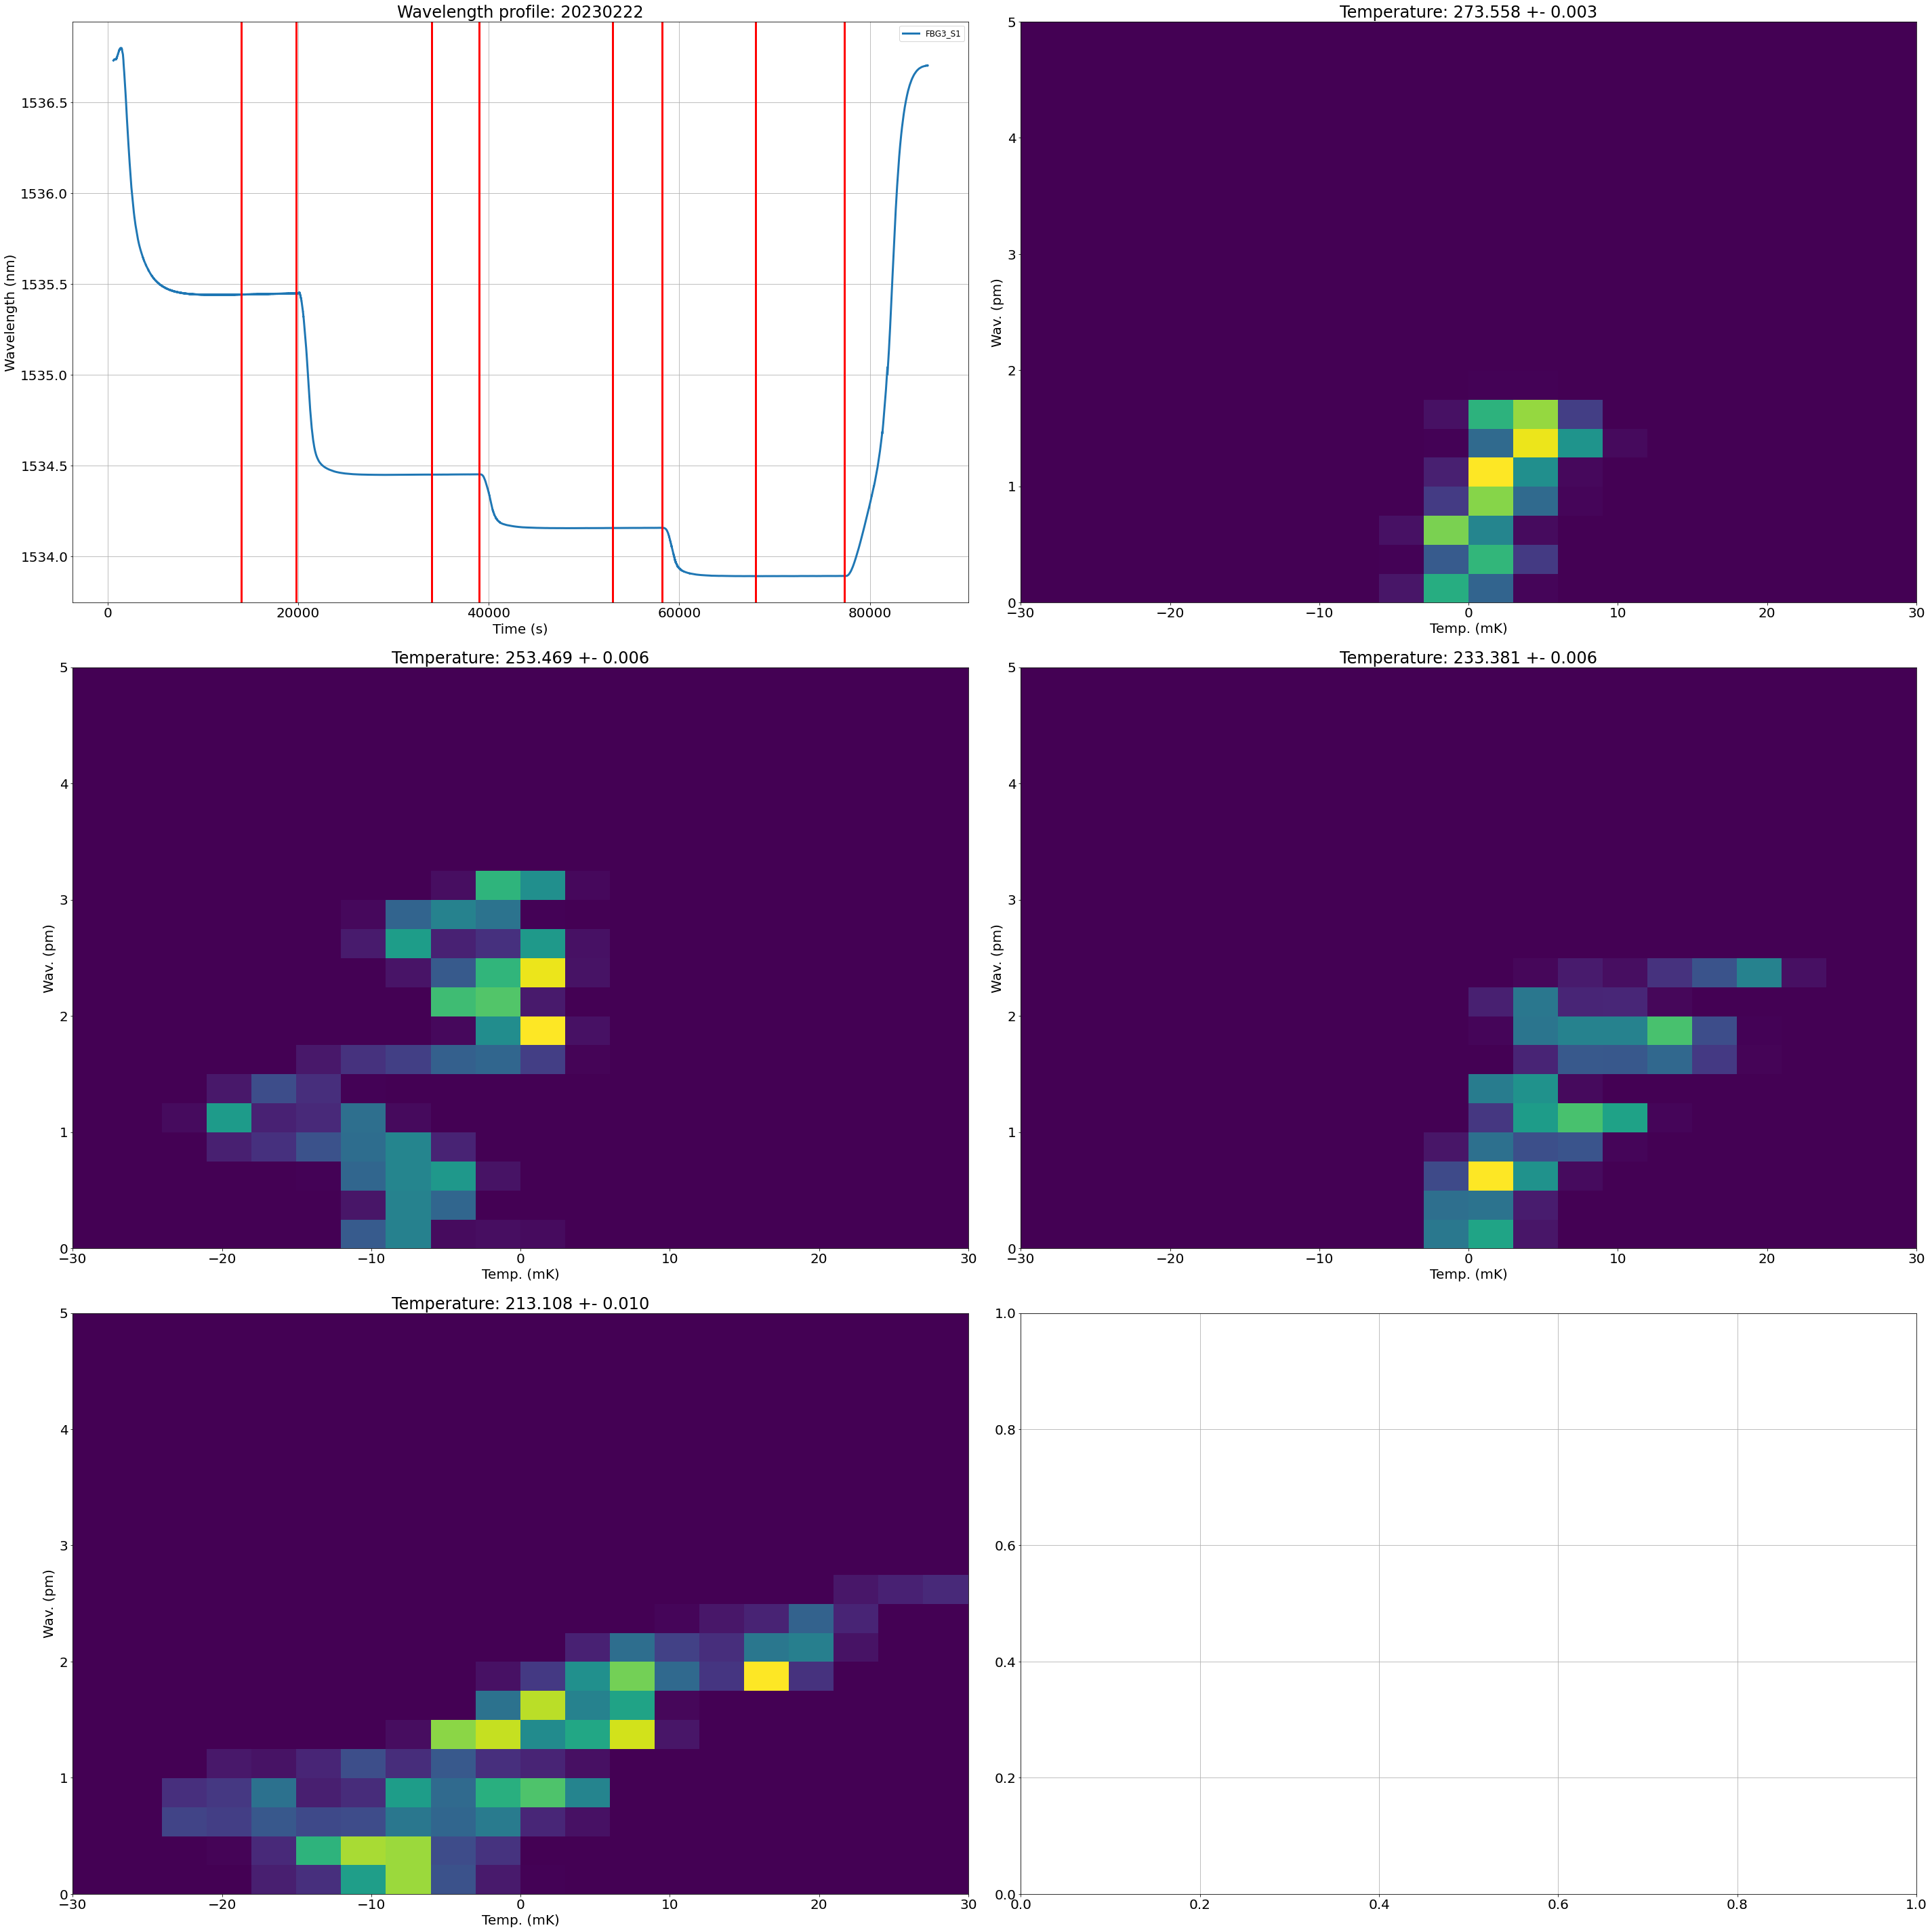

In [14]:
wavoff_plateau21_hist_fig, wavoff_plateau21_hist_ax = create_figure(nrows=3, ncols=2)
wavoff_plateau21_hist_fig.set_size_inches(40, 40)
cnt = 1
wavoff_plateau21_hist_ax[0].plot(peaks_21_av["Timestamp"]-t0, peaks_21_av["Wav1-1"]*1e9, label="FBG3_S1")
wavoff_plateau21_hist_ax[0].set_title("Wavelength profile: " + date)
wavoff_plateau21_hist_ax[0].set_xlabel("Time (s)")
wavoff_plateau21_hist_ax[0].set_ylabel("Wavelength (nm)")
wavoff_plateau21_hist_ax[0].legend(fontsize=12)
for key in plateau_21.keys():
    for col in peaks_21_av.columns:
        if col == "Datetime" or col=="Timestamp" or col == "Date" or col =="Time" or col =="Unnamed: 0" or col[-1]=="r":
            continue
        wavoff_plateau21_hist_ax[0].axvline(x=plateau_21[key][0], color="red")
        wavoff_plateau21_hist_ax[0].axvline(x=plateau_21[key][1], color="red")
        temp_plateau = temp.loc[(temp["Timestamp"]-t0 > plateau_21[key][0]) & (temp["Timestamp"]-t0 < plateau_21[key][1])].reset_index(drop=True)
        value = peaks_21_av.loc[(peaks_21_av["Timestamp"]-t0 > plateau_21[key][0]) & (peaks_21_av["Timestamp"]-t0 < plateau_21[key][1])].reset_index(drop=True)
        temp_plateau, value = manage_data.match_dataframes(temp_plateau, value)
        wavoff_plateau21_hist_ax[cnt].hist2d(
            ((temp_plateau["T1"]) - (temp_plateau["T1"])[0])*1e3,
            ((value[col]) - value[col][0])*1e12,
            label=r"{0} {1:.3f} pm".format(col, np.std((value[col] - value["Wav2-1"])*1e12 - (value[col] - value["Wav2-1"])[0]*1e12 - line(value["Timestamp"]-t0, popt[0], popt[1]))),
            bins=20,
            range=[[-30,30],[0,5]]
        )
        wavoff_plateau21_hist_ax[cnt].set_title(r"Temperature: {0:.3f} +- {1:.3f}".format(np.mean(temp_plateau["T1"]), np.std(temp_plateau["T1"])))
        wavoff_plateau21_hist_ax[cnt].set_ylabel("Wav. (pm)")
        wavoff_plateau21_hist_ax[cnt].set_xlabel("Temp. (mK)")
    cnt += 1
wavoff_plateau21_hist_fig.tight_layout()

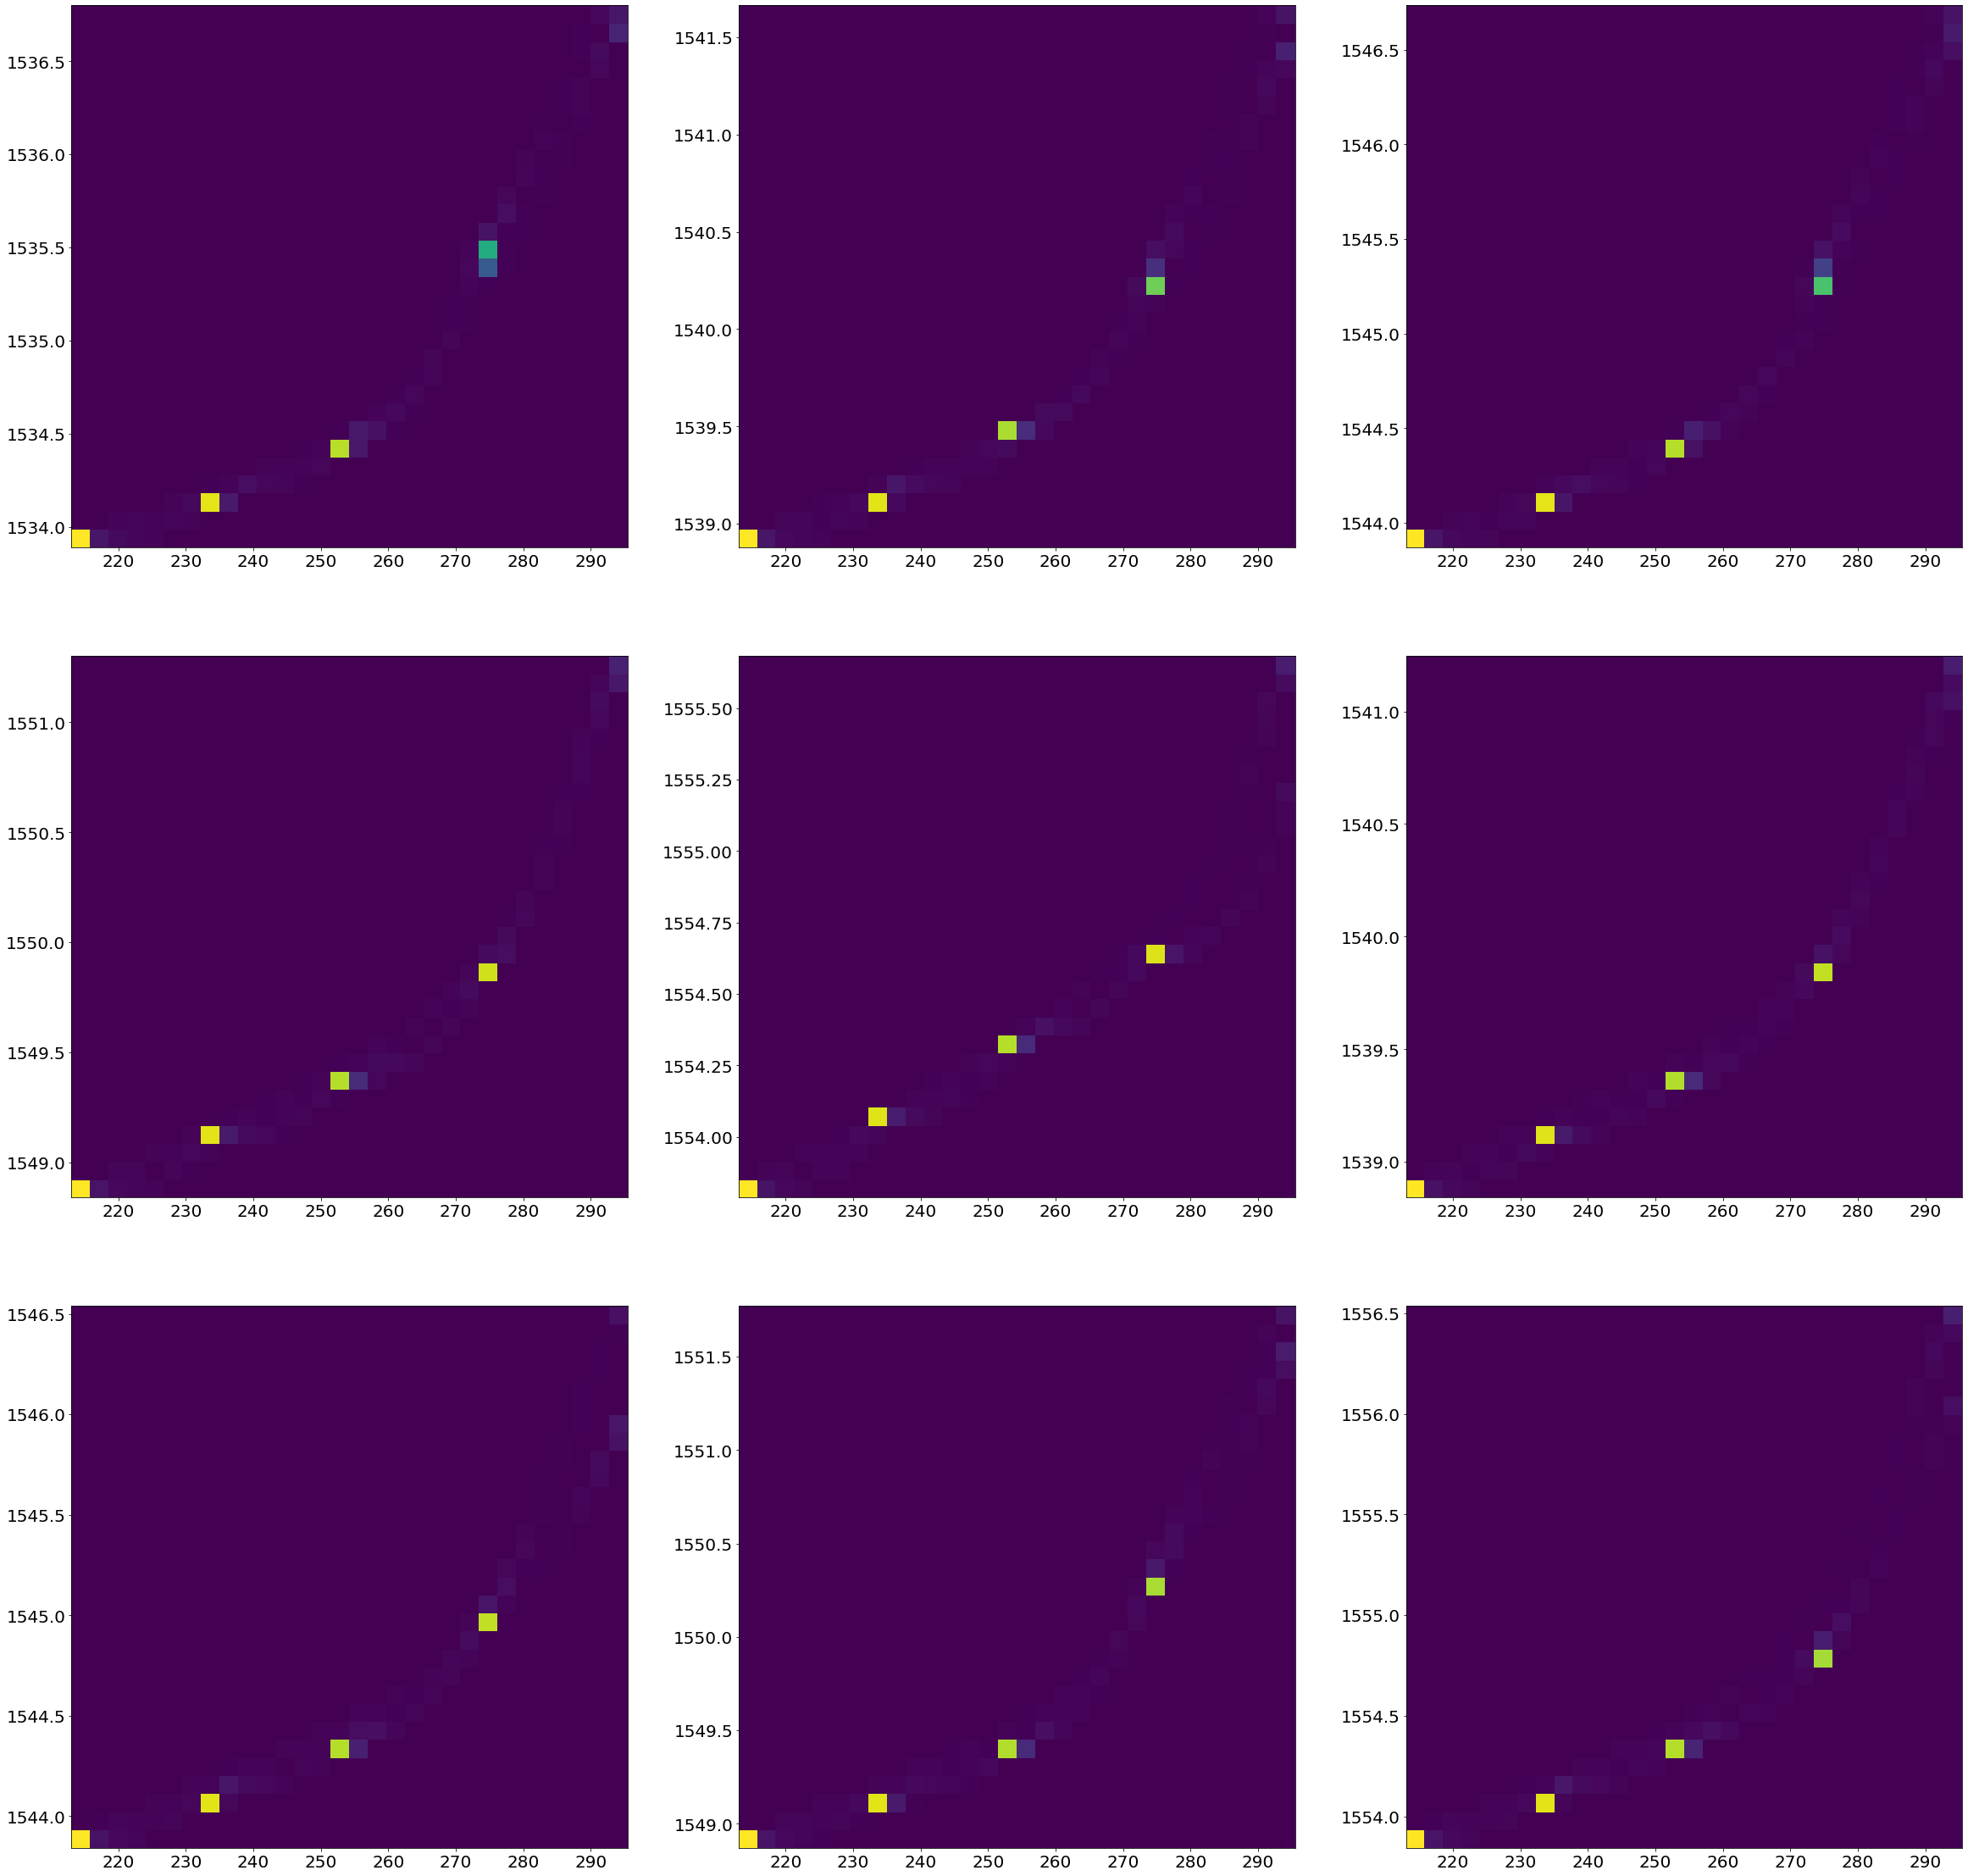

In [15]:
wavoff_plateau21_hist_fig, wavoff_plateau21_hist_ax = create_figure(nrows=3, ncols=3)
wavoff_plateau21_hist_fig.set_size_inches(40, 40)
cnt = 0
for col in peaks_21_av.columns:
    if col == "Datetime" or col=="Timestamp" or col == "Date" or col =="Time" or col =="Unnamed: 0" or col[-1]=="r":
            continue
    t, p = manage_data.match_dataframes(temp, peaks_21_av)
    wavoff_plateau21_hist_ax[cnt].hist2d(
        t["T1"],
        p[col]*1e9,
        bins=30
    )
    cnt += 1

In [20]:
def get_specs(
    path_to_split="",
    pol="P"
    ):
    joint_data = pd.DataFrame()
    for j in range(1,4):
        data_peaks = pd.read_csv(path_to_split + pol+"_spectrums_"+str(j)+".txt", header=0)
        joint_data = pd.concat([joint_data, data_peaks], ignore_index=True, axis=0, keys=data_peaks)
    return joint_data.sort_values(by=["Timestamp"])

In [21]:
specs_p = get_specs(path_to_split=path_to_split_21, pol="P")
specs_s = get_specs(path_to_split=path_to_split_21, pol="S")
specs_av = (specs_p + specs_s)/2

In [26]:
specs_av = specs_av.loc[(specs_av["Wav1-1"]>1532)]

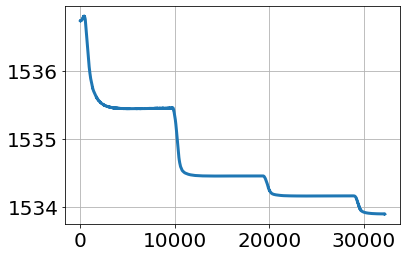

In [27]:
plt.plot(specs_av["Wav1-1"])